# ELG7186 - fall 2022 - Assignment 1 

# Name : Amjad Dife Friend Dife 

## <font color="#660000"> import neccessary libraries </font>

In [1]:
# import neccessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn import svm
#from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:

from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

In [3]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

## <font color="#660000"> Part 0. Dataset Preparation </font>

In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Divide the raw data into appropriate training and test sets for both the images and corresponding labels for use with the subsequent parts of the assignment.</li>
<li>Visualize five samples of each class by plotting a grid using the matplotlib library.</li>
</ul>

------------------------------------

1. for downloading the original dataset i used [1],[2] . 

    the data contains files :
        data_batch_1, data_batch_2,data_batch_3,data_batch_4,data_batch_5,and test_batch. 
2. for loading the dataset and put it in the right shape i have used a function called load_CIFAR10 from [3]

### <font color="#000000">cleaning up the variables to prevent loading the data multiple time then , load the dataset</font>

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('it is Clear , previously loaded data has been cleared')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

### <font color="black"> print the shape of the training and testing data befor choose a suitable sample </font>

In [5]:
print('Training data shape  : ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape      : ', X_test.shape)
print('Test labels shape    : ', y_test.shape)

Training data shape  :  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape      :  (10000, 32, 32, 3)
Test labels shape    :  (10000,)


### <font color="black">Visualize some examples from the dataset.</font>

In [6]:
def visualize_N_Sample(X_train,y_train,n,classesNames):
    num_classes = len(classesNames)
    samples_per_class = n
    for y, cls in enumerate(classesNames):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    

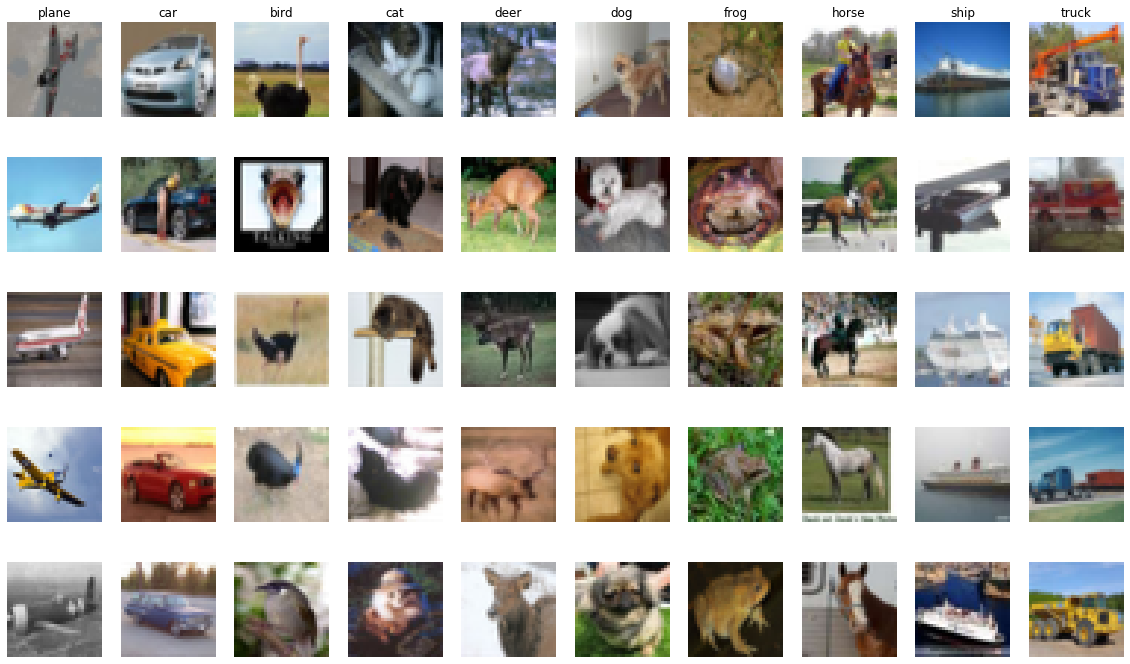

In [7]:
visualize_N_Sample(X_train,y_train,5,['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

### <font color="black">Divide the raw data into appropriate training and test sets</font>

I will take a sample from the original data as follow : 
   - 5000 sample as a training data 
   - 500  sample as a testing data 

In [8]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

### <font color="black"> print the shape of the training and testing data after choose a suitable sample </font>

In [9]:
print('Training data shape  : ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape      : ', X_test.shape)
print('Test labels shape    : ', y_test.shape)

Training data shape  :  (5000, 32, 32, 3)
Training labels shape:  (5000,)
Test data shape      :  (500, 32, 32, 3)
Test labels shape    :  (500,)


### <font color="black"> Reshape the image data into rows </font>

In [10]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [11]:
print('Training data shape  : ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape      : ', X_test.shape)
print('Test labels shape    : ', y_test.shape)

Training data shape  :  (5000, 3072)
Training labels shape:  (5000,)
Test data shape      :  (500, 3072)
Test labels shape    :  (500,)


### scale the images by dividing on 255.0 because in this assignment i will use some algorithms that debends on the distance to get the predicted classes 

In [12]:
scaled_X_train = X_train/255
scaled_X_test  = X_test/255

--------------------------------------------------

## <font color="#660000"> Part 1. k-NN Classifier  </font>

requirement of this part : 

For this section you will implement a simple kNN Classifier on the Cifar10 dataset. To do this you will need to perform the following steps:
- Create a k-NN class. Your class must contain a method that returns predictions for your test set.
- Provide a suitable distance metric that you will use to calculate the nearest neightbours. You may choose the distance metric you believe is most suitable.
- Calculate the k nearest neighbours and make predictions.
- Choose the a value for _k_ that results in the highest accuracy on your test set. Show how you found this value.

When your classifier is working:
- Use sklearn to calculate accuracy and plot a confusion matrix using your predictions.
- Provide a brief discussion of your results

### Bonus:

When you compute the distance metric you can acheive better performance if you vectorize the computation instead of using for loops to iterate through the values. You can earn __0.5 bonus marks__ if you only need one loop, or __1 bonus mark__ if you can omit for loops for a fully vectorized distance calculation (a maximum of 1 bonus mark is available).




--------------------------------------------------------

### Create a k-NN class. 

to use KNN to classify the images it can be done throw two main step : 
<li> preparing the distance matrix in which we keep all the distance between each testing instance and all the training examples. </li>
<li> given this distance matrix , find the k-nearest neighbors and assigned the majority label to be the label of the new instance </li>

<font color="blue">Build the class with the constructor and the main functions, the class consists of :  </font>
<li>constructor </li>
<li>train function to assign the training data to be the attribute of this class , so it can be used to build the distance matrix </li>
<li>predict method to return the predicted values it call 3 different methods for calculating the the distance matrix , in term of performance </li>
<li> three different methods to build the distance matrix </li>




#### - note that : to build this class i have understood the code in [4] and modefied it so i can use it in my notebook

In [13]:
from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange
import time
import operator

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        the training step in KNN is just memorizing the training data. 

        Inputs:
        - X: A numpy array of shape (num_train, D) 
            containing the training data consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):

        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops : Determines which implementation to use to compute distances between training points and testing points.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the test data, where y[i] is the predicted label for the test point X[i].
        """
        # different ways to get the distance matrix. 
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError("Invalid value %d for num_loops" % num_loops)
        # use the perpare distance matrix to get the predicted label to the new instance (from the test samples)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """

        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        # prepare the zero matrix to fill it with the distance 
        dists = np.zeros((num_test, num_train))

        for i in range(num_test):
            for j in range(num_train):
                # compute the L2 distance between the ith test point and the jth training point . 
                dists[i, j] = np.sqrt(np.sum(np.square(X[i, :] - self.X_train[j, :])))
    
        return dists
    


    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis = 1))
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        
        dists = np.sqrt(np.multiply(np.dot(X, self.X_train.T), -2) + np.sum(self.X_train ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis])

        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []

            k_nearest_index = np.argsort(dists[i, :])[:k]

            closest_y = self.y_train[k_nearest_index]
            labels_counts = {}
            for label in closest_y:
                if label in labels_counts.keys():
                    labels_counts[label] += 1
                else:
                    labels_counts[label] = 0
            sorted_labels_counts = sorted(
                labels_counts.items(), key=operator.itemgetter(1), reverse=True)
            y_pred[i] = sorted_labels_counts[0][0]

        return y_pred

        
        

### <font color="black">Compare the performance of the three methods of calculating the L2 distance<font>

to choose the distance metric which i  believe is most suitable i will check the performance of the three methods and i will choose the one with the best performance

In [14]:
def checkPerformance(f, tst):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    tic = time.time()
    f(tst)
    toc = time.time()
    return toc - tic


the Bonus part is associated with this step 

In [15]:
#check the performance 
clf1 = KNearestNeighbor()
clf1.train(scaled_X_train, y_train)

two_loop_time = checkPerformance(clf1.compute_distances_two_loops, scaled_X_test)
one_loop_time = checkPerformance(clf1.compute_distances_one_loop, scaled_X_test)
no_loop_time = checkPerformance(clf1.compute_distances_no_loops, scaled_X_test)

In [16]:
df2 = pd.DataFrame({
"Two loop":[two_loop_time],
"One loop":[one_loop_time],
"No loop":[no_loop_time]
})

df2.style.highlight_min(color = 'lightgreen', axis = 1)

,Two loop,One loop,No loop
0,47.338213,39.689812,0.450027


the method that use noloop is the best in term of the performance 

### Choose the a value for k that results in the highest accuracy on your test set. Show how you found this value

In [18]:
from sklearn.metrics import accuracy_score

k_choices = [5,13,19,21,23,25,27,29,31,101]
k_accuracies = []
# create new instance 
clf = KNearestNeighbor()
# fit the model using training data 
clf.train(scaled_X_train, y_train)

for k in k_choices:
    # get prediction using specific k value
    y_test_pred = clf.predict(scaled_X_test,k,0)
    # calculate the accuracy 
    acc= accuracy_score(y_test, y_test_pred)*100
    k_accuracies.append(acc)

In [19]:
df = pd.DataFrame({"k":k_choices,"accuracy":k_accuracies})
# highlight the max values 
df.style.highlight_max(color = 'lightgreen', axis = 0)

,k,accuracy
0,5,29.000000
1,13,27.600000
2,19,27.400000
3,21,26.400000
4,23,26.800000
5,25,26.400000
6,27,26.200000
7,29,26.400000
8,31,25.000000
9,101,22.600000


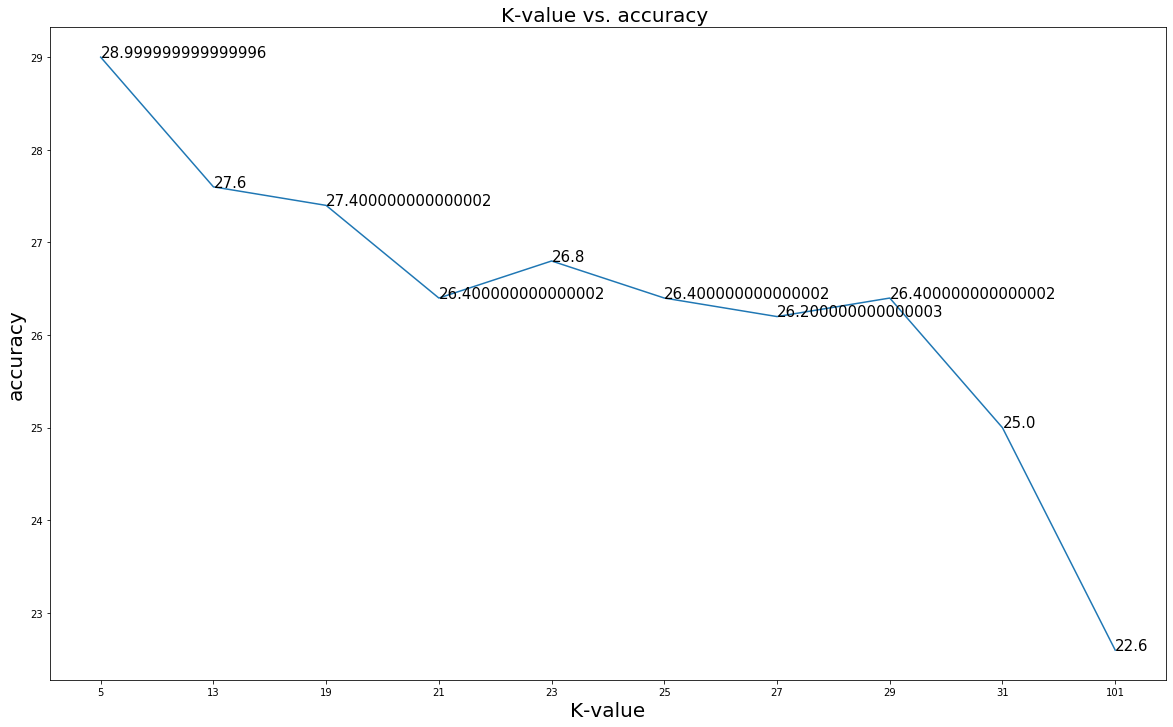

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
k_choices_str = ['5','13','19','21','23','25','27','29','31','101']
ax.plot(k_choices_str,k_accuracies)

ax.set_xlabel("K-value",fontsize=20)
ax.set_ylabel("accuracy",fontsize=20)

ax.set_title("K-value vs. accuracy ",fontsize=20)

for i in range(len(k_choices_str)):
    plt.annotate(str(k_accuracies[i]), xy=(k_choices_str[i], k_accuracies[i]),fontsize=15)
    
plt.show()

#### so the best k is 5 which give the highest accuracy

### use the tuned paramter to train and test the classifier 

In [31]:
# create new instance from the class 
knn_clf = KNearestNeighbor()

# train : memorize the train instances 
knn_clf.train(scaled_X_train, y_train)

# get the prediction for the test set , by using the tuned parameter 
y_test_pred = knn_clf.predict(X=scaled_X_test,k=5,num_loops=0)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print(f"The model handle {num_correct} correctly out of {num_test}, its Accuracy:{accuracy*100:.2f}%") 


The model handle 145 correctly out of 500, its Accuracy:29.00%


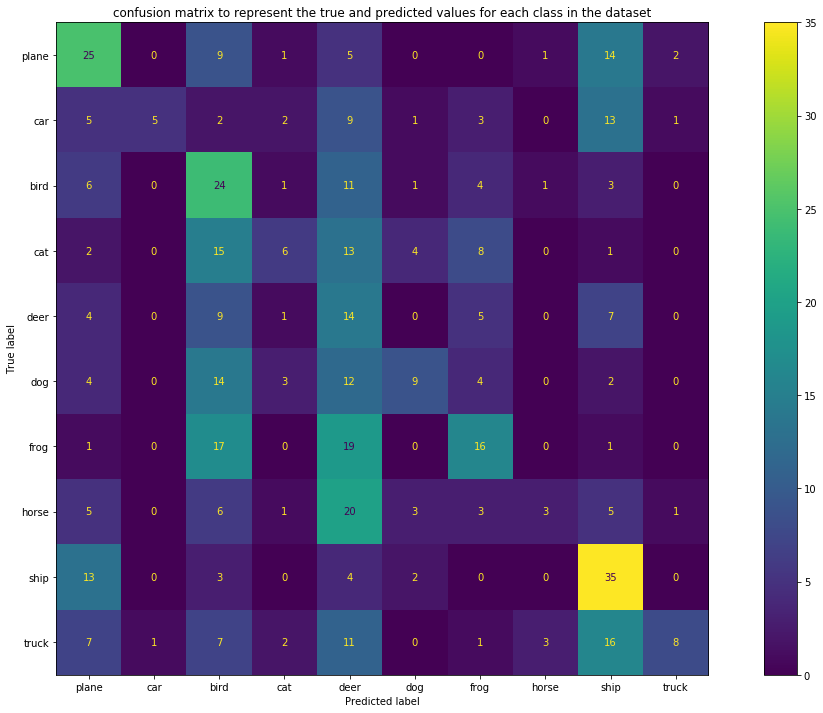

In [32]:
### plot the confusion matrix 

from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
disp.plot()
plt.title("confusion matrix to represent the true and predicted values for each class in the dataset")
plt.show()

### Provide a brief discussion of your results

#### Error Analysis :

* from the confusion matrix we can keep track the true and predicted class 
* as shown the knn classifier with the best parameter classified 35 ship,24 bird and 25 plan correctlly 
* in the other hand the model :
     - the classifier classified 20 hourses as a deer , 19 frog as a deer , 17 frog as a deer , which meen that the model has a problem of classifing the frog , deer, and also the bird . these are the most segnificant mistakes 

--------------------------------------------------

## <font color="#660000"> Part 2. Logistic Regression   </font>

### Part 2. Logistic Regression requirement

For this section you will perform binary classification using logistic regression. Just as in Part 1. you will use the Cifar10 dataset, however to obtain a result for each class using logistic regression you will need to use a One-vs-Rest (OvR) approach to acheive multi-class classification.

Using ```LogisticRegression()``` in sklearn, write a function to execute the OvR strategy for the Cifar10 classes. Do not use the built-in ```OneVsResClassifier()``` method. You will need to follow these basic steps:
- Train a binary classifier for each class, where the target class is a "positive" results and the combination of the remaining classes are "negative". For Cifar10 you will need 10 models.
- For each test sample compute the probabilities for each model
- Select the argmax of the probabilities to obtain the predicted class

Collect your predictions from the test set and compute the accuracy score and plot a confusion matrix.

#### use one host encoding technique to get the target class as "positive" results and the combination of the remaining classes are "negative"

In [34]:
y_train2 = y_train.copy()
y_test2 = y_test.copy()
check_set = y_test.copy()

In [35]:
# Obtain the binarized labels (OvR)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train2 = mlb.fit_transform(y_train2.reshape((-1,1)))
y_test2 = mlb.fit_transform(y_test2.reshape((-1,1)))

In [36]:
y_train2[3]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [37]:
# for training 
y1 = y_train2[:,0]
y2 = y_train2[:,1]
y3 = y_train2[:,2]
y4 = y_train2[:,3]
y5 = y_train2[:,4]
y6 = y_train2[:,5]
y7 = y_train2[:,6]
y8 = y_train2[:,7]
y9 = y_train2[:,8]
y10 = y_train2[:,9]


# for testing 
yT1 = y_test2[:,0]
yT2 = y_test2[:,1]
yT3 = y_test2[:,2]
yT4 = y_test2[:,3]
yT5 = y_test2[:,4]
yT6 = y_test2[:,5]
yT7 = y_test2[:,6]
yT8 = y_test2[:,7]
yT9 = y_test2[:,8]
yT10 = y_test2[:,9]


#### Train a binary classifier for each class, where the target class is a "positive" results and the combination of the remaining classes are "negative". For Cifar10 you will need 10 models

In [39]:
from sklearn.linear_model import LogisticRegression

def manual_OVR(X_train,y_train,X_test,y_test):
    """
    used to make OVR model 
    Input  : X_train,y_train,X_test,y_test
    Output : returns the probabilities of each model (y_pred) and the model itself (oVoClf)
    """
    Clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    
    # get prediction 
    predicted_labes = Clf.predict(X_test)
    
    # get predicted classification probabilities 
    y_pred = Clf.predict_proba(X_test)[:,1].reshape(-1,1)
    
    return y_pred 

#### For each test sample compute the probabilities for each model

In [40]:
# build models 
y1_pred = manual_OVR(scaled_X_train,y1,scaled_X_test,yT1)
y2_pred = manual_OVR(scaled_X_train,y2,scaled_X_test,yT2)
y3_pred = manual_OVR(scaled_X_train,y3,scaled_X_test,yT3)
y4_pred = manual_OVR(scaled_X_train,y4,scaled_X_test,yT4)
y5_pred = manual_OVR(scaled_X_train,y5,scaled_X_test,yT5)
y6_pred = manual_OVR(scaled_X_train,y6,scaled_X_test,yT6)
y7_pred = manual_OVR(scaled_X_train,y7,scaled_X_test,yT7)
y8_pred = manual_OVR(scaled_X_train,y8,scaled_X_test,yT8)
y9_pred = manual_OVR(scaled_X_train,y9,scaled_X_test,yT9)
y10_pred = manual_OVR(scaled_X_train,y10,scaled_X_test,yT10)

/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

#### Select the argmax of the probabilities to obtain the predicted class

In [41]:
#combine all the predicted results form the 4 models
y_all = np.hstack((y1_pred, y2_pred, y3_pred,y4_pred,y5_pred,y6_pred,y7_pred,y8_pred,y9_pred,y10_pred))

#Use argmax to aggregate confidence scores and obtain the final predicted labels and obtain the performance
m1 = mlb.classes_[np.argmax(y_all, axis=1)]

#### Collect your predictions from the test set and compute the accuracy score and plot a confusion matrix.

In [42]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(list(check_set),list(m1))

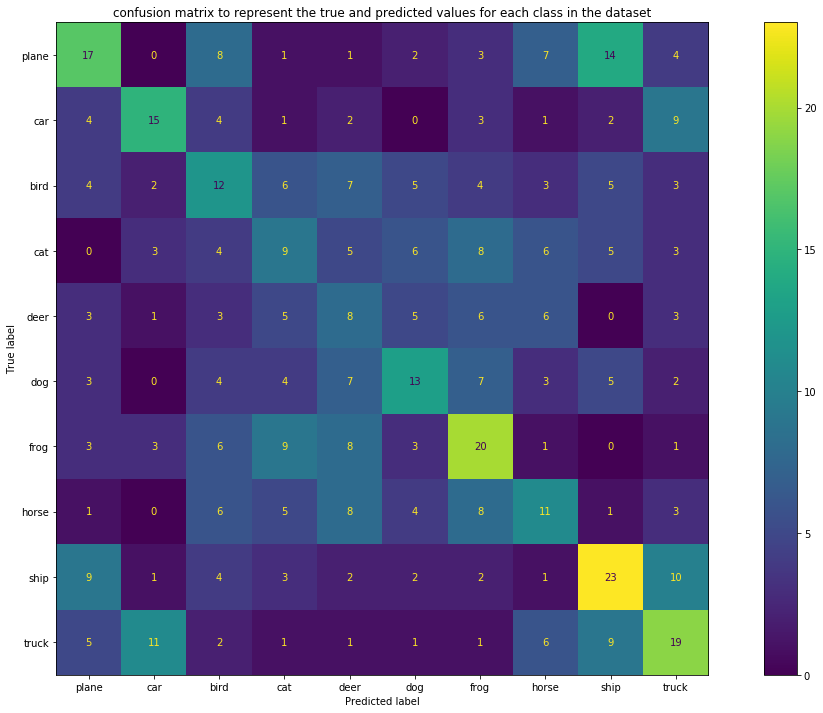

In [45]:
# ploting the confusion matrix 
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
disp.plot()
plt.title("confusion matrix to represent the true and predicted values for each class in the dataset")
plt.show()


In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(list(check_set), list(m1))*100

29.4

### Error Analysis: 

- the logistic regression classifier is quit better than knn classificer :
    * just remember that knn had a problem in classifing the frog , deer, and also the bird . these are the most segnificant mistakes
    * here we can notice that logistic regression is able to classify frog class a bit better than knn 
    * on the other hand LR classifier has a problem in classifing car , truck and ship . these are the most segnificant mistakes

-------------------------------------------

## <font color="#660000"> Part 3. Support Vector Machine (SVM) Classification   </font>

### Part 3.requirement

In Part 3. you will use Scikit-learn to perform classification, again on the Cifar10 dataset. You can use the built in SVM library for classification. As with logistic regression, SVM is designed for binary classification. However, in this case Scikit-learn will handle the OvR models behind the scenes.

Your task is to compare different modes of the SVM and determine the best performer. 

Create an SVM baseline using the <code>LinearSVC()</code> function. Make sure to use the primal solution and use "ovr" for multiclass Calculate the accuracy score for comparison.

Next you will explore the effect of the cost parameter on the accuracy.
    <ul>
    <li>Run the classification with a range of C values For example: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]</li>
    <li>Plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

Add a regularization term.
    <ul>
    <li>Rerun the above experiment, but this time use L1 regularization.</li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>

For the final experiment you will use the ```SVC()``` function to run the classifer with a kernel.
    <ul>
    <li>Use a radial basis function when training a new model</li>
    <li>Find the optimal combination of values for the cost and gamma parameters. Use the following values in your loop:<br/>
        <div style="margin-left:40px"><code>
        for cost in [0.01, 0.1, 1, 10, 100]:<br/>
        &emsp;for gamma in [0.01, 0.1, 1, 10, 100]:
        </code></div>
    </li>
    <li>Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.</li>
    </ul>


Choose the model with the highest accuracy and plot the confusion matrix. In your discussion explain the results of your experiments and the reason for increased performance from the baseline (if any). Comment on the effect of the cost-paramenter and the L1 penalty on accuracy as well as any overfitting you observed. Discuss the confusion matrix of the model accuracy and provide some reasons for high-values found off the main diagonal.

### Bonus Mark
Instead of using raw pixel values compute an alternate feature representation for your dataset and re-run train the model. Compare the accuracy of the model using the new feature representation with the model trained with pixel values.

-----------------------------

#### Create an SVM baseline using the LinearSVC() function. Make sure to use the primal solution and use "ovr" for multiclass Calculate the accuracy score for comparison.

In [13]:

#build the baseline model ,Make sure to use the primal solution and use "ovr" for multiclass
BaseLine_model = svm.LinearSVC(dual=False,multi_class='ovr')
BaseLine_model.fit(scaled_X_train, y_train)
#get the prediction using the baseline model. 
yPred = BaseLine_model.predict(scaled_X_test)


In [14]:
def getAccuracy(y_test,yPred):
    Acc = accuracy_score(list(y_test), list(yPred))*100
    return Acc

In [15]:
from sklearn.metrics import accuracy_score

# calculate the accuracy for the comparision 
baseLine_accuracy = getAccuracy(y_test,yPred)

In [16]:
print(f"Baseline accuracy : {baseLine_accuracy} %")

Baseline accuracy : 24.0 %


#### Next you will explore the effect of the cost parameter on the accuracy.

In [17]:
def buildSVM_C_valueEffect(c_value):
    # build the model 
    model = svm.LinearSVC(dual=False,multi_class='ovr',C=c_value)
    model.fit(scaled_X_train, y_train)
    # get prediction using the model 
    y_model_Pred = model.predict(scaled_X_test)
    #calculate the accuracy of the classifier 
    model_Acc = getAccuracy(y_test,y_model_Pred)
    return model_Acc
    

#### Run the classification with a range of C values For example: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]

In [18]:
# Run the classification with a range of C values For example: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
C_values=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 ]
acc_C_values = []

for c in C_values:
    accu = buildSVM_C_valueEffect(c)
    acc_C_values.append(accu)

/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


#### Plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.

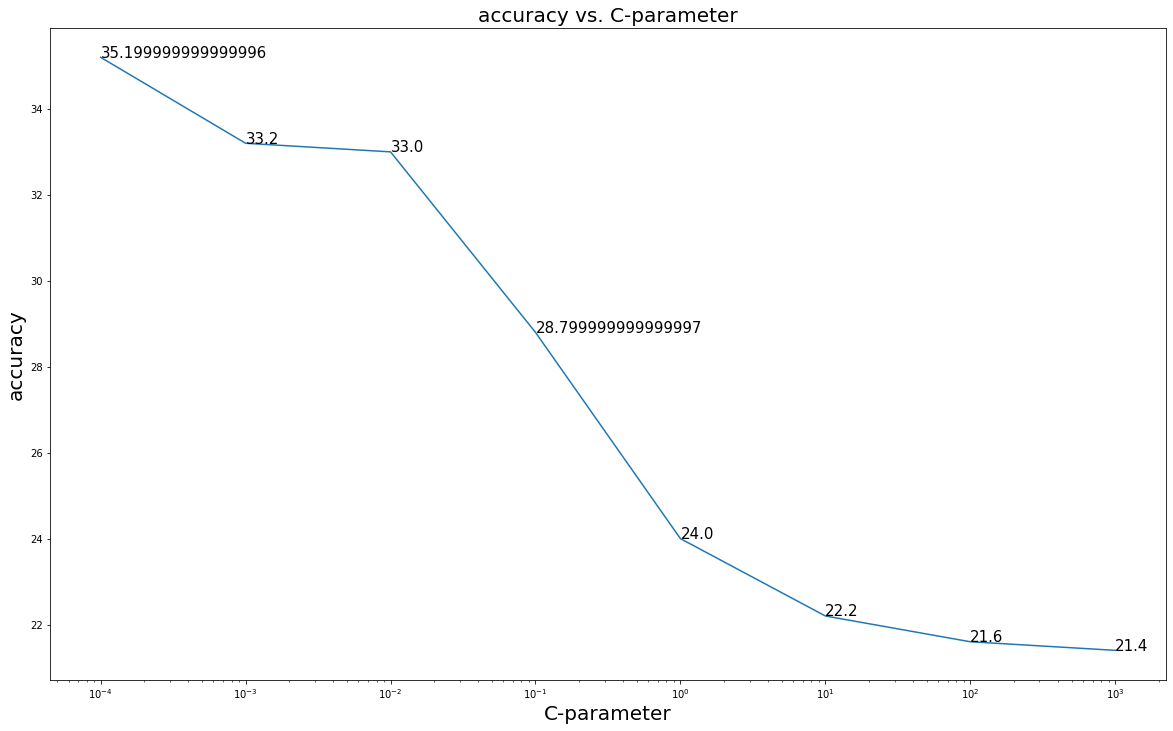

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(C_values,acc_C_values)
ax.set_xscale('log')
ax.set_xlabel("C-parameter",fontsize=20)
ax.set_ylabel("accuracy",fontsize=20)
ax.set_title("accuracy vs. C-parameter",fontsize=20)

for i in range(len(C_values)):
    plt.annotate(str(acc_C_values[i]), xy=(C_values[i], acc_C_values[i]),fontsize=15)
    
plt.show()

#### Add a regularization term

In [20]:
def buildSVM_C_value_Regularization_Effect(c_value):
    # build the model 
    model = svm.LinearSVC(dual=False,multi_class='ovr',C=c_value,penalty="l1")
    model.fit(scaled_X_train, y_train)
    # get prediction using the model 
    y_model_Pred = model.predict(scaled_X_test)
    #calculate the accuracy of the classifier 
    model_Acc = getAccuracy(y_test,y_model_Pred)
    return model_Acc

#### Rerun the above experiment, but this time use L1 regularization.

In [21]:
acc_C_values_l1_regularization = []
#Rerun the above experiment, but this time use L1 regularization.
for c in C_values:
    accu = buildSVM_C_value_Regularization_Effect(c)
    acc_C_values_l1_regularization.append(accu)

/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/amjad/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: Con

In [22]:
acc_C_values_l1_regularization

[11.4, 11.4, 30.8, 35.8, 24.6, 22.8, 22.2, 22.0]

#### Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale.

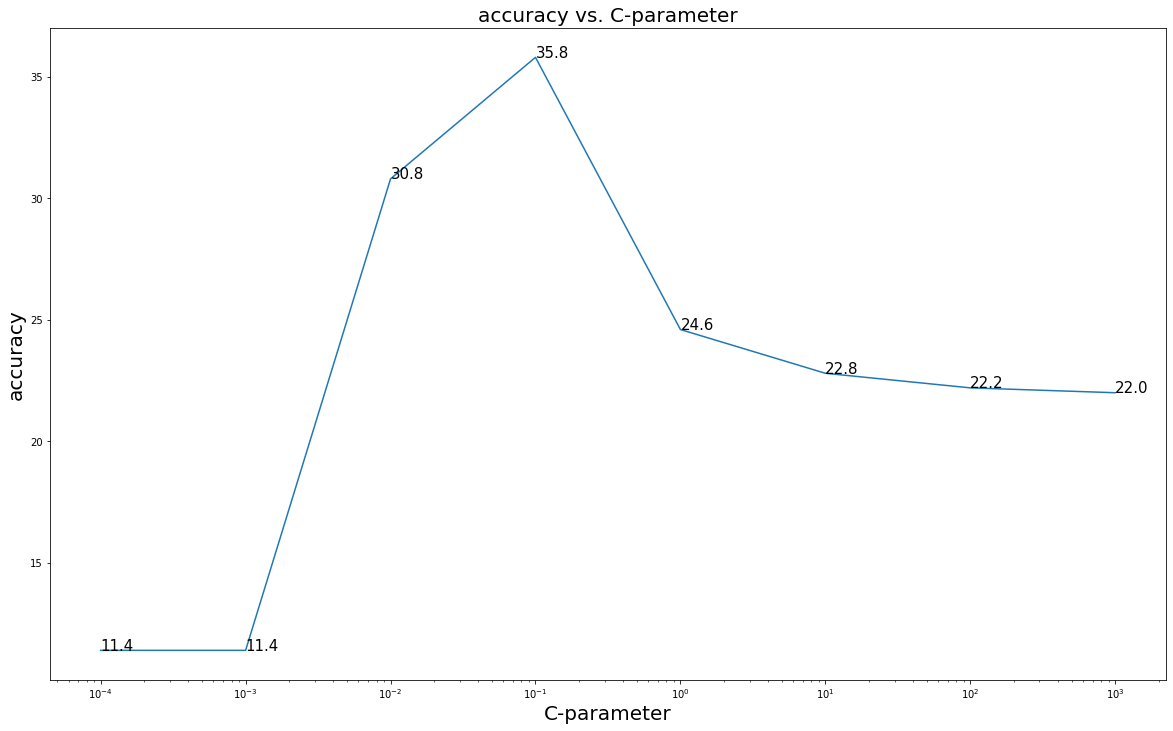

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(C_values,acc_C_values_l1_regularization)
ax.set_xscale('log')
ax.set_xlabel("C-parameter",fontsize=20)
ax.set_ylabel("accuracy",fontsize=20)
ax.set_title("accuracy vs. C-parameter",fontsize=20)

for i in range(len(C_values)):
    plt.annotate(str(acc_C_values_l1_regularization[i]), xy=(C_values[i], acc_C_values_l1_regularization[i]),fontsize=15)
    
plt.show()

#### For the final experiment you will use the SVC() function to run the classifer with a kernel.

##### Use a radial basis function when training a new model

In [24]:
# use the default values for the cost and gamma 

model2 = svm.SVC(kernel='rbf', decision_function_shape='ovr')
model2.fit(scaled_X_train, y_train)
yPred2 = model2.predict(scaled_X_test)

# calculate the accuracy for the model with the default parameters  
model2_accuracy = getAccuracy(y_test,yPred2)

In [25]:
model2_accuracy

40.400000000000006

##### Find the optimal combination of values for the cost and gamma parameters.

In [26]:
def builtModel_cost_gamma_effect(X_train,X_test,y_train,y_test,c,g):
    model = svm.SVC(kernel='rbf', decision_function_shape='ovr', C=c,gamma=g)
    model.fit(X_train, y_train)
    yPred = model.predict(X_test)

    # calculate the accuracy  
    model_accuracy = getAccuracy(y_test,yPred)
    
    return model_accuracy

In [27]:
cost_gamma_str = []
cost_gamma_acc = []

for cost in [0.01, 0.1, 1, 10, 100]:
    for gamma in [0.01, 0.1, 1, 10, 100]:
        acc = builtModel_cost_gamma_effect(scaled_X_train,scaled_X_test,y_train,y_test,cost,gamma)
        st = f"cost : {cost}, gamma : {gamma}"
        cost_gamma_acc.append(acc)
        cost_gamma_str.append(st)
        

##### Again, plot the results as an accuracy vs. C-parameter curve on a logarithmic scale

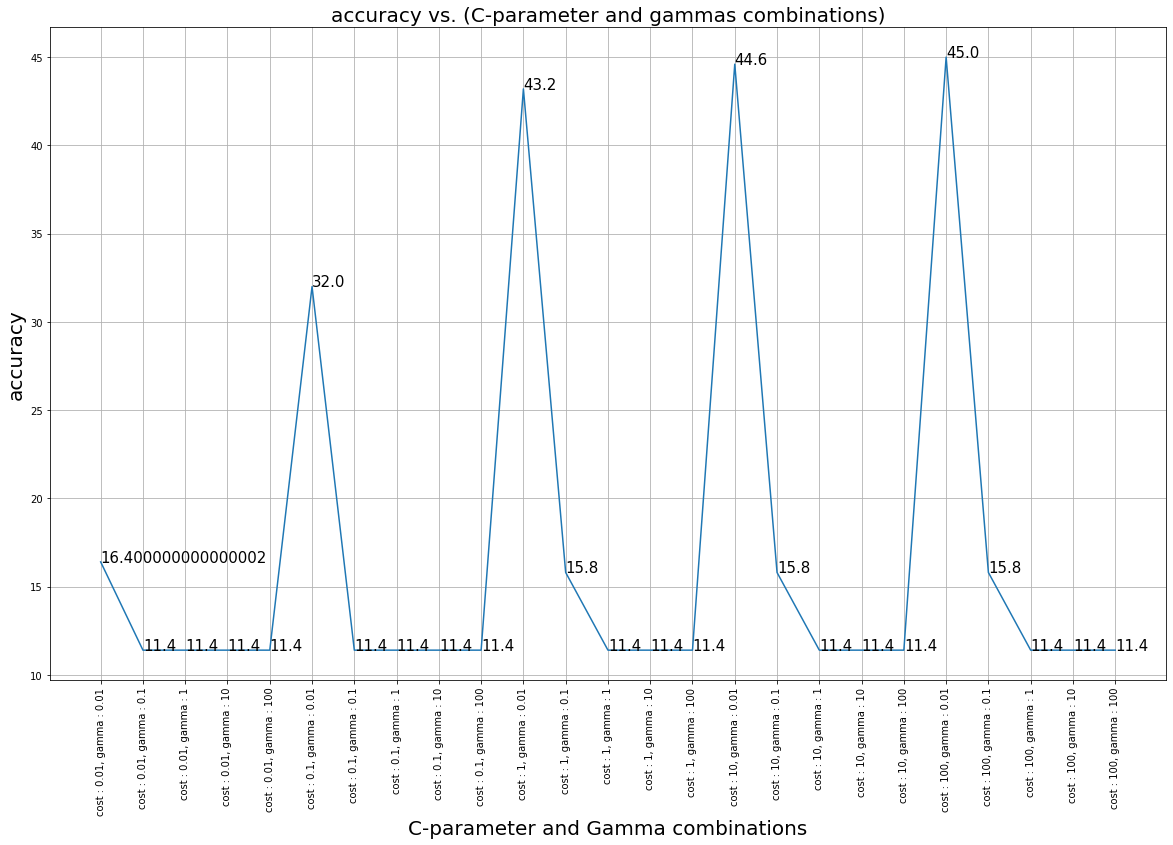

In [36]:
import matplotlib.pyplot as plt
# ax.tick_params(axis='x', labelrotation=45)
fig, ax = plt.subplots()
ax.plot(cost_gamma_str,cost_gamma_acc)
# ax.set_xscale('log')
ax.set_xlabel("C-parameter and Gamma combinations",fontsize=20)
ax.set_ylabel("accuracy",fontsize=20)
ax.set_title("accuracy vs. (C-parameter and gammas combinations)",fontsize=20)
plt.xticks(rotation = 90)
for i in range(len(cost_gamma_str)):
    plt.annotate(str(cost_gamma_acc[i]), xy=(cost_gamma_str[i], cost_gamma_acc[i]),fontsize=15)
plt.grid()
plt.show()

### Choose the model with the highest accuracy and plot the confusion matrix.

In [33]:
df = pd.DataFrame({"combination":cost_gamma_str,"accuracy":cost_gamma_acc})
# highlight the max values 
df.style.highlight_max(color = 'lightgreen', axis = 0)

,combination,accuracy
0,"cost : 0.01, gamma : 0.01",16.400000
1,"cost : 0.01, gamma : 0.1",11.400000
2,"cost : 0.01, gamma : 1",11.400000
3,"cost : 0.01, gamma : 10",11.400000
4,"cost : 0.01, gamma : 100",11.400000
5,"cost : 0.1, gamma : 0.01",32.000000
6,"cost : 0.1, gamma : 0.1",11.400000
7,"cost : 0.1, gamma : 1",11.400000
8,"cost : 0.1, gamma : 10",11.400000
9,"cost : 0.1, gamma : 100",11.400000


### build the model with the best parameters that gives the highest accuracy then plot confusion matrix 

In [34]:
model = svm.SVC(kernel='rbf', decision_function_shape='ovr', C=100,gamma=0.01)
model.fit(scaled_X_train, y_train)
yPred = model.predict(scaled_X_test)

# calculate the accuracy  
model_accuracy = getAccuracy(y_test,yPred)
print(f"the accuracy of the  model with the best parameteres is : {model_accuracy}% ")

the accuracy of the  model with the best parameteres is : 45.0% 


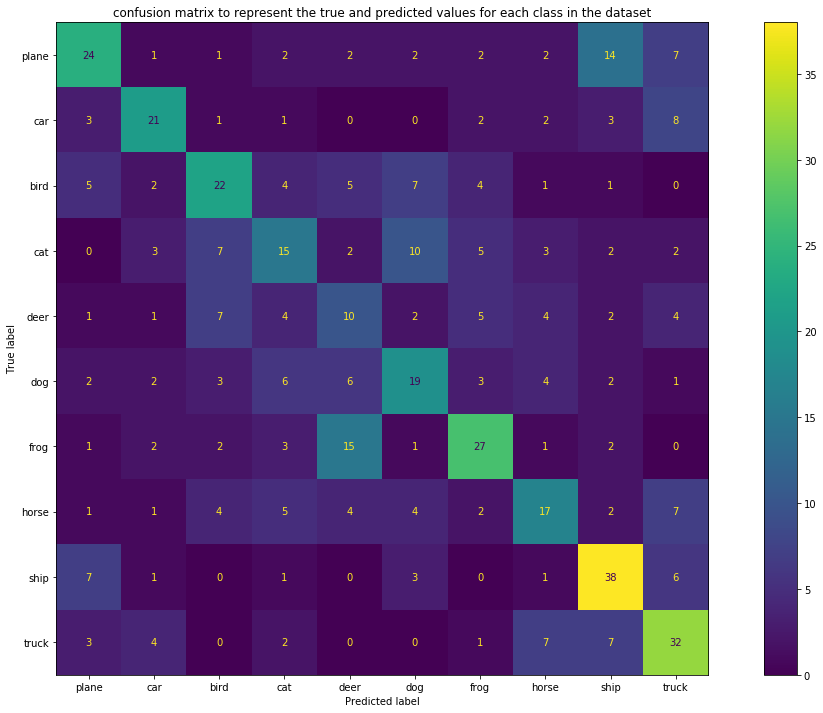

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
disp.plot()
plt.title("confusion matrix to represent the true and predicted values for each class in the dataset")
plt.show()

#### Disccusion

- explain the results of your experiments and the reason for increased performance from the baseline (if any).
- Comment on the effect of the cost-paramenter and the L1 penalty on accuracy as well as any overfitting you observed. 
- Discuss the confusion matrix of the model accuracy and provide some reasons for high-values found off the main diagonal.

    * : in this part, I conducted different experiments in which I was trying to enhance the accuracy of the baseline model which was 24.0%. 
    - first, I checked the effect of using different values for the cost parameter. as a result the accuracy decreased when the cost increased. note that for my entire experiment I used 5000, and 500 samples for training and testing sets respectively. 
    - in the second experiment  I checked the effect of using l1 distance, as a result, the accuracy increased till it got the highest value when the cost equaled 0.1, then it decreased again. 
    - finally, I checked the effect of using different combinations for Gamma and the cost, I noticed that Gamma and the cost together have a significant effect on the accuracy. 
    - I used the best combination to build the model, as an analysis of the confusion matrix of the accuracy of the model. the model's ability to classify the class for quite better than the ability of the baseline model. we can see that by looking at the high values found the main diagonal. 
  


## <font color="#660000"> Part 4. Write a Conclusion  </font>

Write a conclusion comparing the results from each part of the assignment. Comment on the suitability of each method for this task.

- what I have learned in this assignment : 
- I have learned the basics of loading images and visualizing samples from each class in the data. 
- I checked the effect of using traditional machine learning algorithms in classifying the images, as a result, both KNN, Logistic regression, and SVM are not suitable for classifying the images. 
- by looking at the way that both KNN, LR, and SVM both of them do not care about the images themselves or the features in them. instead, they are based on distance. So, distance is not sufficient for image classification. 

- comparing the results from each part of the assignment:
    * the best accuracy  for  KNN classifier      was : 29%
    * the best acccuracy for  Logistic Regression was : 29.4% 
    * the best accuracy  for  SVM                 was : 45%
 which means that svm is the best classifier compared with the two other classifiers. 
 but still both of the three classifier is not able to classify most of the samples in our test set. 

## <strong> References </strong> 

1. https://www.cs.toronto.edu/~kriz/cifar.html
2. Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
3. https://cs231n.github.io/assignments2022/assignment1/
4. https://tomaxent.com/2017/03/02/cs231n-Assignment-1-kNN/
5. https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

